$\gamma$ Ray Burst (GRB)

We have to explore the following data set and cluster the fast and slow GRB. Then, compare with the literature.

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])




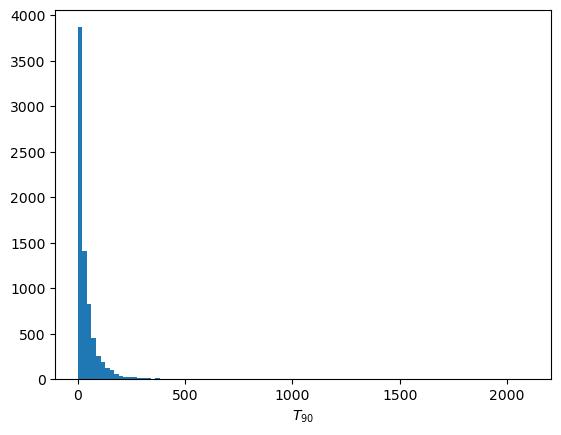

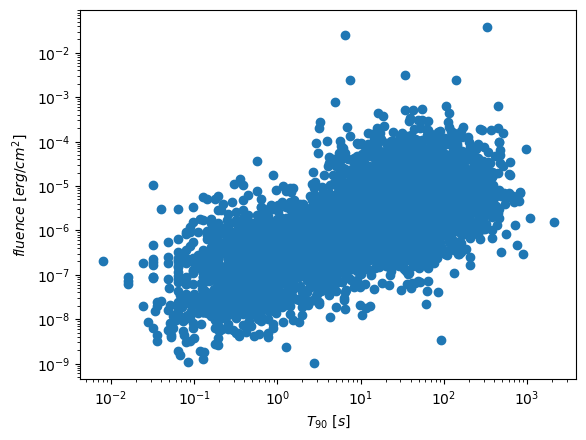

In [80]:
#fluence
fluence = data[9]
#T_90
T90 = data[6]

T90 = np.array(T90, dtype=float)
fluence = np.array(fluence, dtype=float)


for i in range(len(T90)):
    if T90[i] == -999 or fluence[i] == -999:
        T90[i] = -1000
        fluence[i] = -1000

T90 = T90[T90 != -1000]
fluence = fluence[fluence != -1000]


plt.hist(T90, bins=np.linspace(min(T90), max(T90), 100))
plt.xlabel('$T_{90}$')
plt.show()

plt.scatter(T90, fluence)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')
plt.show()

And now we are ready to cluster! 

First: K-Means Clustering

Text(0, 0.5, '$fluence \\ [erg/cm^2]$')

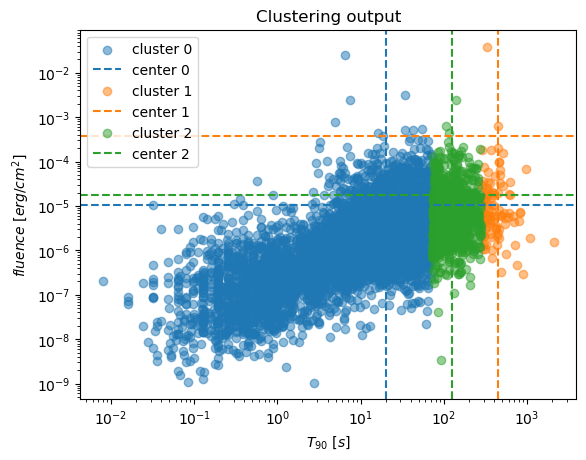

In [89]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_cluster = 3

#we need an array shape like [[x_1,y_1], ..., [x_n,y_n]]
X = np.vstack((T90, fluence)).T


model = KMeans(n_clusters=n_cluster, n_init='auto').fit(X)
centers = model.cluster_centers_

labels = model.predict(X)

c = ['C0', 'C1', 'C2']
for i in range(n_cluster):
    plt.scatter(X[labels==i, 0], X[labels==i, 1], alpha=0.5, label=f'cluster {i}')
    plt.axvline(centers[i,0], color=c[i], linestyle='--', label=f'center {i}')
    plt.axhline(centers[i,1], color=c[i], linestyle='--')
    plt.xscale('log')
    plt.yscale('log')

plt.title('Clustering output')
plt.legend()
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')


(100.0, 200.0)

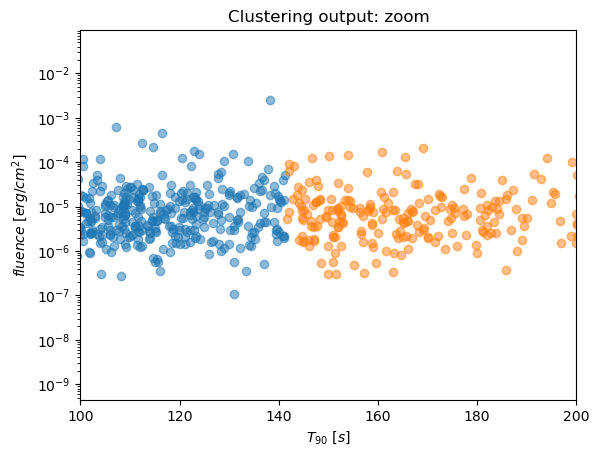

In [81]:
for ii in range(n_cluster):
    plt.scatter(X[labels==ii,0], X[labels==ii,1] ,alpha=0.5)
    #plt.xscale('log')
    plt.yscale('log')

plt.title('Clustering output: zoom')
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')
plt.xlim([100,200])

Second: Mean-shift Clustering

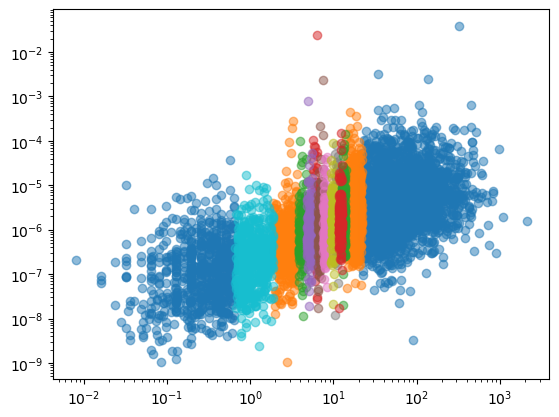

In [46]:
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.4
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

labels = ms.predict(X)


for ii in range(max(labels)):
    plt.scatter(X[labels==ii,0], X[labels==ii,1],alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')